In [1]:
import time
import itertools
import numpy as np

import qiskit
from qiskit import *
from qiskit.quantum_info import Statevector
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA
from qiskit.opflow.state_fns import StateFn, CircuitStateFn
from qiskit.providers.aer import StatevectorSimulator, AerSimulator

from qiskit.opflow import CircuitSampler

from qiskit.ignis.mitigation.measurement import CompleteMeasFitter # you will need to pip install qiskit-ignis
from qiskit.ignis.mitigation.measurement import complete_meas_cal

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
cmap = plt.get_cmap("plasma") #'viridis'

from modules.utils import *

from qae import *

import datetime

In [2]:
print(qiskit.__version__, np.__version__)

0.17.4 1.20.1


# Plotting results

In [3]:
#plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=16)
#plt.rc('font', family='serif')

In [13]:
temp = np.load("data/QAEAnsatz_scaling_losses.npz", allow_pickle=True)
losses0 = temp["losses"]
Ls = temp["Ls"]

In [14]:
# It took 51 hrs to obtain these results.
# However, you can confirm the validity by just executing the circuit once for the optimized parameters (as demonstrated down below)
temp2 = np.load("data/QAEAnsatz_scaling_MPS_script_L-32_tracked-losses_results.npz",allow_pickle=True)
losses32 = temp2["losses"]

In [15]:
Ls = list(Ls)
Ls += [32]
Ls

[3, 4, 8, 16, 32]

<ipython-input-38-2bc784230189>:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


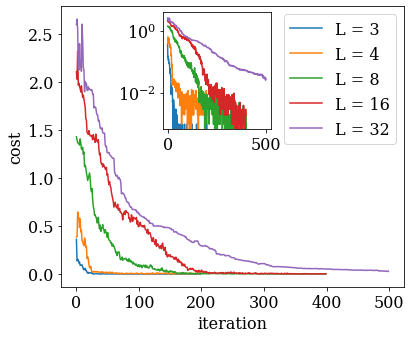

In [38]:
fig, ax = plt.subplots(figsize=(6,5))
for i in range(4):
    ax.plot(np.array(losses0[i]),label=f"L = {Ls[i]}")
ax.plot(losses32[1],label=f"L = {Ls[-1]}")
ax.legend()

left, bottom, width, height = [0.4,0.61, 0.25, 0.325]
ax2 = fig.add_axes([left, bottom, width, height])
for i in range(4):
    ax2.plot(np.array(losses0[i]),label=f"L = {Ls[i]}")
ax2.plot(losses32[1],label=f"L = {Ls[-1]}")
ax2.set_yscale("log")

#ax.set_xlim(0,405)
#ax.set_yscale("log")
ax.set_ylabel("cost", fontsize=16)
ax.set_xlabel("iteration", fontsize=16)
plt.tight_layout()
plt.savefig("plots/QAEAnsatz_Ising-scaling.pdf")
plt.savefig("plots/QAEAnsatz_Ising-scaling.png")

# Size scaling with exact diagonalization

In [3]:
#IBMQ.load_account() # this then automatically loads your saved account
#provider = IBMQ.get_provider(hub='ibm-q-research')

In [4]:
#device = provider.backend.ibmq_rome # 6 bogota ; 4 rome

In [5]:
### Real device execution:
#backend = device 

### Simulation with noise profile from real device
#backend = qiskit.providers.aer.AerSimulator.from_backend(device)

### Simulation without noise
backend = qiskit.providers.aer.AerSimulator()
#backend = StatevectorSimulator()

In [8]:
### Preliminaries
L = 5
num_trash = 2
anti = 1 # 1 for ferromagnetic Ising model, -1 for antiferromagnet

filename = "data/QAEAnsatz_scaling"

In [9]:
gz = 0
gx = 0.3

In [10]:
ED_state, ED_E, ham = ising_groundstate(L, anti, np.float32(gx), np.float32(gz))
Sen = ED_E
Smag = ED_state.T.conj()@Mag(L,anti)@ED_state

In [11]:
def prepare_circuit(thetas, L=6, num_trash=2, init_state=None, measurement=True,vqe=False):
    # QAE ansatz
    QAE_circ = QAEAnsatz(num_qubits = L, num_trash_qubits= num_trash, trash_qubits_idxs = list(range(num_trash)), measure_trash=measurement).assign_parameters(thetas)
    # initialize state vector
    initcirc = QuantumCircuit(QuantumRegister(L,"q"),ClassicalRegister(num_trash, 'c'))
    initcirc.initialize(init_state, initcirc.qubits)
    # compose circuits
    fullcirc = initcirc.compose(QAE_circ)
    return fullcirc

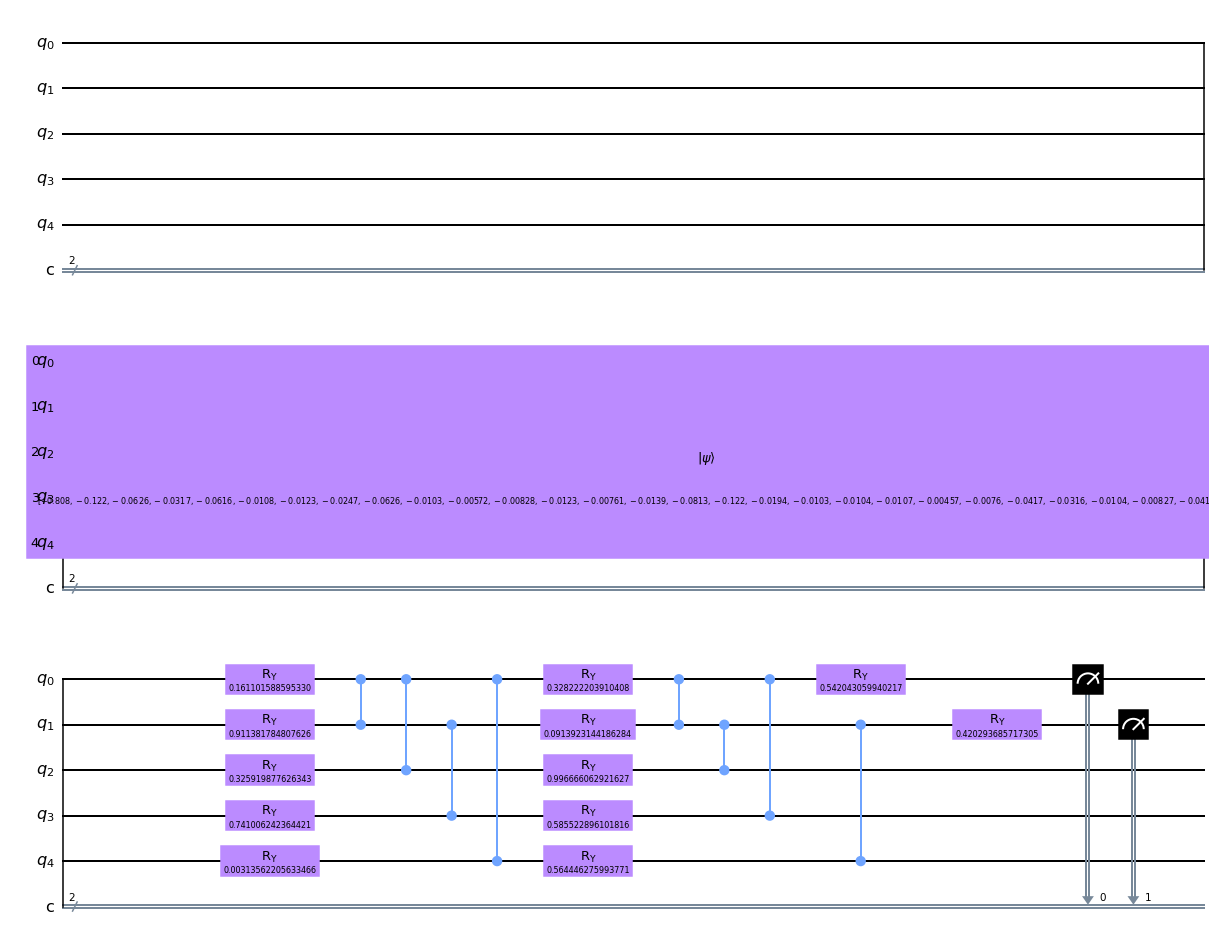

In [13]:
circ = prepare_circuit(thetas = np.random.rand(2*L+2), L = L, init_state = ED_state)
circ.draw("mpl")

In [168]:
### Execute circuit
count = 0
def run_circuit(thetas, L, num_trash, init_state, vqe=False, shots=100, meas_fitter = None):
    #global count
    #count += 1
    #print(count, "thetas: ", thetas)
    circ = prepare_circuit(thetas, L, num_trash, init_state, vqe=vqe)
    tcirc = qiskit.transpile(circ, backend)
    # Execute the circuit 
    job_sim = backend.run(tcirc, shots=shots,seed_simulator=333, seed_transpiler=444) # , seed_simulator=123, seed_transpiler=234 fix seed to make it reproducible
    result = job_sim.result()
    # Results without mitigation
    counts = result.get_counts()
    if meas_fitter != None:
        # Get the filter object
        meas_filter = meas_fitter.filter

        # Results with mitigation
        mitigated_results = meas_filter.apply(result)
        counts = mitigated_results.get_counts(0)
    return counts

In [15]:
res = run_circuit(thetas = np.random.rand(num_trash*L+num_trash), L = L, num_trash = num_trash, init_state = ED_state, shots=1000)

In [16]:
res

{'01': 182, '11': 284, '10': 188, '00': 346}

In [17]:
def count_ones(string):
    return np.sum([int(_) for _ in string])

In [18]:
count_ones("01010111")

5

In [19]:
[_ for _ in res]

['01', '11', '10', '00']

In [20]:
[_ for _ in res if _ != "0" * num_trash]

['01', '11', '10']

In [21]:
np.sum([res[_]*count_ones(_) for _ in res if _ != "0" * num_trash]) # all measurement results except "000"

938

In [22]:
### Optimize circuit
def cost_function_single(thetas, L, num_trash, init_state, shots=1000, vqe=True, param_encoding=False, x=0, meas_fitter=None):
    """ Optimizes circuit """
    if param_encoding: thetas = feature_encoding(thetas, x) 
    out = run_circuit(thetas, L, num_trash, init_state, vqe=vqe, shots=shots, meas_fitter=meas_fitter)
    cost = np.sum([out[_]*count_ones(_) for _ in out if _ != "0" * num_trash]) # all measurement results except "000"
    return cost/shots

def cost_function(thetas, L, num_trash, init_states, shots=1000, vqe=True, param_encoding=False, x=0, meas_fitter=None):
    """ Optimizes circuit """
    cost = 0.
    for init_state in init_states:
        cost += cost_function_single(thetas, L, num_trash, init_state, shots, vqe, param_encoding, meas_fitter=meas_fitter)
    return cost/len(init_states)

def optimize(init_states, L=6, num_trash=2, thetas=None, shots=1000, max_iter=400, vqe=True, param_encoding=False, x=0, pick_optimizer = None,
            meas_fitter=None):
    if thetas is None:
        n_params = (num_trash*L+num_trasg)*2 if param_encoding else (num_trash*L+num_trash)
        thetas = np.random.uniform(0, 2*np.pi, n_params) # initial parameters without feature encoding
        
    #print("Initial cost: {:.3f}".format(cost_function(thetas, L, num_trash, init_states, shots, vqe, param_encoding, x)))
    
    counts, values, accepted = [], [], []
    def store_intermediate_result(eval_count, parameters, mean, std, ac):
        # counts.append(eval_count)
        values.append(mean)
        accepted.append(ac)

    # Initialize optimizer
    if pick_optimizer == "cobyla":
        optimizer = COBYLA(maxiter=max_iter, tol=0.0001)
    if pick_optimizer == "adam" or pick_optimizer == "ADAM":
        optimizer = qiskit.algorithms.optimizers.ADAM(maxiter=max_iter)
    # optimizer = L_BFGS_B(maxfun=300, maxiter=max_iter)#, factr=10, iprint=- 1, epsilon=1e-08)
    if pick_optimizer == "spsa" or pick_optimizer == None:
        optimizer = SPSA(maxiter=max_iter,
                         #blocking=True,
                         callback=store_intermediate_result,
                         #learning_rate=0.3,
                         #perturbation=0.1
                         ) # recommended from qiskit (first iteraction takes quite long)
                           # to reduce time figure out optimal learning rate and perturbation in advance
    start_time = time.time()
    ret = optimizer.optimize(
                            num_vars=len(thetas),
                            objective_function=(lambda thetas: cost_function(thetas, L, num_trash, init_states, shots, vqe, param_encoding, x, meas_fitter=meas_fitter)),
                            initial_point=thetas
                            )
    print("Time: {:.5f} sec".format(time.time()-start_time))
    print(ret)
    return ret[0], values, accepted



In [23]:
thetas_opt_mitigated, losses, accepted = optimize([ED_state], max_iter=120, L=5, meas_fitter=None) #, pick_optimizer="adam")

Time: 9.77129 sec
(array([-0.27620814, -0.07832044,  1.52004177, -0.21485598, -1.55547985,
        3.17875132,  1.62009326,  4.51055365,  1.37937503,  4.38401314,
       -2.03482615,  4.54135205]), 0.027, 360)


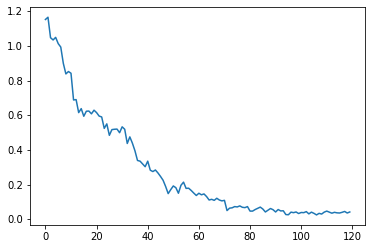

In [24]:
plt.plot(losses)

# Scaling

In [40]:
Ls = [3,4,8,16] #note that L=16 may take up few hours, it is faster with MPS further below
max_iter = [400] * len(Ls)
num_trashs = np.log(Ls)/np.log(2)
num_trashs = np.array(num_trashs, dtype="int")
gz = 0
gx = 0.3

In [30]:
losses = [None] * len(Ls); accepted = [None] * len(Ls); thetas_opt= [None] * len(Ls)

In [ ]:
# may have to re-run some sizes when it gets stuck in local minima
for j,(L,num_trash) in enumerate(zip(Ls,num_trashs)):
    print(L,num_trash)
    ED_state, ED_E, ham = ising_groundstate(L, anti, np.float32(gx), np.float32(gz))
    thetas_opt[j], losses[j], accepted[j] = optimize([ED_state], max_iter=max_iter[j], L=L, num_trash=num_trash, meas_fitter=None) #, pick_optimizer="adam")
    plt.plot(losses[j])
    plt.show()

In [ ]:
np.savez(filename + "_losses", losses=losses, thetas_opt = thetas_opt, Ls=Ls, max_iter=max_iter, num_trashs=num_trashs)

In [41]:
temp = np.load(filename + "_losses.npz", allow_pickle=True)
losses0 = temp["losses"]

Text(0.5, 0, 'iterations')

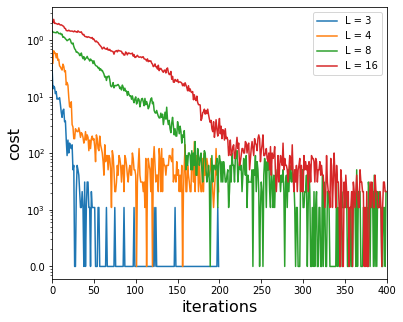

In [58]:
fig, ax = plt.subplots(figsize=(6,5))
for i in range(4):
    ax.plot(np.array(losses0[i]) + 1e-4,label=f"L = {Ls[i]}")
ax.legend()
ax.set_xlim(0,400)
ax.set_yscale("log")
ax.set_yticks([1,1e-1,1e-2,1e-3,1e-4])
ax.set_yticklabels(["$10^{}$".format(i) for i in range(4)] + ["0.0"])
ax.set_ylabel("cost", fontsize=16)
ax.set_xlabel("iterations", fontsize=16)

In [59]:
min_losses = [np.min(l) for l in losses0]

In [60]:
min_losses

[0.0, 0.0, 0.0, 0.0]

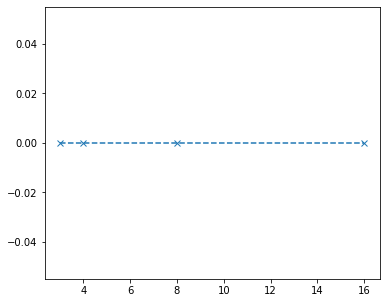

In [61]:
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(Ls, min_losses,"x--")
#ax.set_yscale("log")
#ax.set_xscale("log")

# 32 Qubits result from cluster re-evaluated
To confirm we are not bullshitting w/o having to re-run the script for 50+ hours (without loss tracking during optimization 24 hrs), you can re-evaluate with the optimized parameters. For this result with 32 qubits we need to use MPS.

In [29]:
def DMRG_Ising(L, J, g, chi_max=30, bc_MPS='finite'):
    print("finite DMRG, transverse field Ising model")
    print("L={L:d}, g={g:.2f}".format(L=L, g=g))
    model_params = dict(L=L, J=J, g=g, bc_MPS=bc_MPS, conserve=None)
    M = TFIChain(model_params)
    product_state = ["up"] * M.lat.N_sites
    psi = MPS.from_product_state(M.lat.mps_sites(), product_state, bc=M.lat.bc_MPS)
    dmrg_params = {
        'mixer': None,  # setting this to True helps to escape local minima
        'max_E_err': 1.e-10,
        'trunc_params': {
            'chi_max': chi_max,
            'svd_min': 1.e-10
        },
        'combine': True
    }
    info = dmrg.run(psi, M, dmrg_params)  # the main work...
    E = info['E']
    print("E = {E:.13f}".format(E=E))
    print("final bond dimensions: ", psi.chi)
    mag_x = np.sum(psi.expectation_value("Sigmax"))
    mag_z = np.sum(psi.expectation_value("Sigmaz"))
    print("magnetization in X = {mag_x:.5f}".format(mag_x=mag_x))
    print("magnetization in Z = {mag_z:.5f}".format(mag_z=mag_z))
    #if L < 20:  # compare to exact result
    #    from tfi_exact import finite_gs_energy
    #    E_exact = finite_gs_energy(L, 1., g)
    #    print("Exact diagonalization: E = {E:.13f}".format(E=E_exact))
    #    print("relative error: ", abs((E - E_exact) / E_exact))
    return E, psi #, M

### Preliminaries
qiskit_chi = 100
L = 8
num_trash = int(np.log(L)/np.log(2))
anti = 1 # 1 for ferromagnetic Ising model, -1 for antiferromagnet
g = 0.05
J=anti
filename = "data/QAEAnsatz_scaling_MPS_script_L-32_tracked-losses"

backend = qiskit.providers.aer.AerSimulator(method="matrix_product_state",
                                            precision="single",
                                            matrix_product_state_max_bond_dimension = qiskit_chi,
                                            matrix_product_state_truncation_threshold = 1e-10,
                                            #mps_sample_measure_algorithm = "mps_apply_measure", #alt: "mps_probabilities" 
                                           )

from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 333

def qiskit_state(psi0):
    # G is only the local tensor (not multiplied by any singular values) - see https://tenpy.readthedocs.io/en/latest/reference/tenpy.networks.mps.html
    A_list = [psi0.get_B(i, form="G").to_ndarray().transpose([1,0,2]) for i in range(L)]
    for i,A in enumerate(A_list):
        A_list[i] = (A[0], A[1])
    S_list = [psi0.get_SR(i) for i in range(L-1)] # skip trivial last bond; hast to be of size L-1
    return (A_list, S_list)

def prepare_circuit(thetas, L=6, num_trash=2, init_state=None, measurement=True,vqe=False):
    # QAE ansatz
    QAE_circ = QAEAnsatz(num_qubits = L, num_trash_qubits= num_trash, trash_qubits_idxs = list(range(L//2-1,L//2-1+num_trash)), measure_trash=measurement).assign_parameters(thetas)
    # initialize state vector
    initcirc = QuantumCircuit(QuantumRegister(L,"q"),ClassicalRegister(num_trash, 'c'))
    if init_state != None:
        initcirc.set_matrix_product_state(qiskit_state(init_state))
    # compose circuits
    fullcirc = initcirc.compose(QAE_circ)
    return fullcirc

### Execute circuit
count = 0
def run_circuit(thetas, L, num_trash, init_state, vqe=False, shots=100, meas_fitter = None):
    #global count
    #count += 1
    #print(count, "thetas: ", thetas)
    #print(L, num_trash)
    circ = prepare_circuit(thetas, L, num_trash, init_state, vqe=vqe)
    #circ.draw("mpl")
    #tcirc = qiskit.transpile(circ, backend)
    # Execute the circuit 
    job_sim = backend.run(circ, shots=shots, seed_simulator=333, seed_transpiler=444) #fix seed to make it reproducible
    result = job_sim.result()
    # Results without mitigation
    counts = result.get_counts()
    if meas_fitter != None:
        # Get the filter object
        meas_filter = meas_fitter.filter

        # Results with mitigation
        mitigated_results = meas_filter.apply(result)
        counts = mitigated_results.get_counts(0)
    return counts

def count_ones(string):
    return np.sum([int(_) for _ in string])

### Optimize circuit
def cost_function_single(thetas, L, num_trash, init_state, shots=1000, vqe=True, param_encoding=False, x=0, meas_fitter=None):
    """ Optimizes circuit """
    if param_encoding: thetas = feature_encoding(thetas, x) 
    out = run_circuit(thetas, L, num_trash, init_state, vqe=vqe, shots=shots, meas_fitter=meas_fitter)
    cost = np.sum([out[_]*count_ones(_) for _ in out if _ != "0" * num_trash]) # all measurement results except "000"
    return cost/shots

def cost_function(thetas, L, num_trash, init_states, shots=1000, vqe=True, param_encoding=False, x=0, meas_fitter=None):
    """ Optimizes circuit """
    cost = 0.
    for init_state in init_states:
        cost += cost_function_single(thetas, L, num_trash, init_state, shots, vqe, param_encoding, meas_fitter=meas_fitter)
    return cost/len(init_states)

def optimize(init_states, L=6, num_trash=2, thetas=None, shots=1000, max_iter=400, vqe=True, param_encoding=False, x=0, pick_optimizer = None,
            meas_fitter=None):
    if thetas is None:
        n_params = (num_trash*L+num_trasg)*2 if param_encoding else (num_trash*L+num_trash)
        thetas = np.random.uniform(0, 2*np.pi, n_params) # initial parameters without feature encoding
        
    #print("Initial cost: {:.3f}".format(cost_function(thetas, L, num_trash, init_states, shots, vqe, param_encoding, x)))
    
    counts, values, accepted = [], [], []
    def store_intermediate_result(eval_count, parameters, mean, std, ac):
        # counts.append(eval_count)
        values.append(mean)
        accepted.append(ac)

    # Initialize optimizer
    if pick_optimizer == "cobyla":
        optimizer = COBYLA(maxiter=max_iter, tol=0.0001)
    if pick_optimizer == "adam" or pick_optimizer == "ADAM":
        optimizer = qiskit.algorithms.optimizers.ADAM(maxiter=max_iter)
    # optimizer = L_BFGS_B(maxfun=300, maxiter=max_iter)#, factr=10, iprint=- 1, epsilon=1e-08)
    if pick_optimizer == "spsa" or pick_optimizer == None:
        optimizer = SPSA(maxiter=max_iter,
                         #blocking=True,
                         callback=store_intermediate_result,
                         #learning_rate=0.3,
                         #perturbation=0.1
                         ) # recommended from qiskit (first iteraction takes quite long)
                           # to reduce time figure out optimal learning rate and perturbation in advance
    start_time = time.time()
    ret = optimizer.optimize(
                            num_vars=len(thetas),
                            objective_function=(lambda thetas: cost_function(thetas, L, num_trash, init_states, shots, vqe, param_encoding, x, meas_fitter=meas_fitter)),
                            initial_point=thetas
                            )
    print("Time: {:.5f} sec".format(time.time()-start_time))
    print(ret)
    return ret[0], values, accepted

This was the initial test without loss tracking to see if it works, here we achieve 0.0

In [24]:
temp2 = np.load("data/QAEAnsatz_scaling/QAEAnsatz_scaling_MPS_script_L-32_results.npz",allow_pickle=True) # 500 iterations, gx = 0.3, chi=100 (but resulting bond dimension of state much smaller)

In [25]:
psi0 = temp2["psi0"].item()
thetas_opt = temp2["thetas_opt"][0]
L = psi0.L

In [26]:
loss_final = cost_function_single(thetas_opt, L, int(np.log(L)/np.log(2)), psi0, shots=1000)

In [27]:
print(f"Result for L = {L}: loss_opt = {loss_final} with optimal parameters {thetas_opt}")

Result for L = 32: loss_opt = 0.0 with optimal parameters [ 4.83855054 -0.20582669  6.83525964  6.21561499  1.94371101  1.81630798
 -2.44834111  2.88498123  7.81926284  3.11987048  4.37616758  4.97561373
  1.44112904  2.13434186  1.40920099  6.83006267  5.5905621   0.16458605
  0.30815472  2.17978814  4.40622637  4.91121821  6.02030696  5.30211198
  0.39306616  5.9249213  -0.98698015  0.90086792  2.15806054  2.99258229
  1.94737421 -1.18349407 -1.88232239  8.32568445  6.20363456  3.11065863
  4.82745289 -0.56261306 -1.25618723  3.60737977  5.72683799  3.52368627
 -0.68207825 -1.53779217  5.16929927 -1.29041715  4.31125081  5.19327236
  2.3255499   3.29342905 -1.13838463  0.26985152  3.88154487  4.611061
  5.61231369  3.64121651  6.20467819  7.34565202  0.74564719  2.02414372
  7.75811751 -0.72283332  6.32894993  4.41188814  4.81020359  1.73088927
  6.73079369  2.70860382  6.45612467  4.99078111  0.01792506 -0.04260768
  4.02136698  6.97120237  1.72843076  4.83951581  8.15791455  0.2841

This was the second attempt with loss tracking (run 1 got stuck in a local minima), where we achieve 0.03. From the looks of it, it seems it has not fully converged and would probably reach 0.0 as above if continued further

In [30]:
temp2 = np.load("data/QAEAnsatz_scaling_MPS_script_L-32_tracked-losses_results.npz",allow_pickle=True) # 500 iterations, gx = 0.3, chi=100 (but resulting bond dimension of state much smaller)

In [32]:
psi0 = temp2["psis"][1]
thetas_opt = temp2["thetas_opt"][1]
L = psi0.L

/home/kkottmann/TeNPy/tenpy/tools/optimization.py:308: UserWarning: Couldn't load compiled cython code. Code will run a bit slower.
  warnings.warn("Couldn't load compiled cython code. Code will run a bit slower.")


In [33]:
loss_final = cost_function_single(thetas_opt, L, int(np.log(L)/np.log(2)), psi0, shots=1000)

In [34]:
print(f"Result for L = {L}: loss_opt = {loss_final} with optimal parameters {thetas_opt}")

Result for L = 32: loss_opt = 0.03 with optimal parameters [ 6.21676459 -1.55776429  2.84439856  3.301513    2.07886255  5.67643171
  3.50247431  5.84086743  1.64367106  1.11376773  2.53941036  1.69663221
  1.47292149  3.00041416 -1.16119221  4.26513816  2.20638967  2.18709795
  4.12388773  0.3708488   3.12146944  2.37876178  3.29402502  5.55660998
  1.17407458  3.00632402  2.29374058  0.18987393  0.23470515  1.12183805
  6.20631059  0.74957526  3.65378116  1.54123766  2.57887947  1.24851182
  4.8197619   4.90642999  6.46265771  4.38958421  3.01961285  0.18158946
  3.45754455  6.79818957  5.58190116  3.60408904  3.8778992   7.02948568
  3.25533895  4.73484338  4.70245539  2.40527401  6.14016219  4.15921922
  5.96725584  2.47082308  7.15496531  3.11336783  4.78194967  3.22412708
  1.90111938  2.65975529  2.50538548  5.43719036  4.8352712   6.31349783
  1.91406539  2.44427131  5.21442657  6.23449834  3.84184492  4.60104775
  4.95927497  0.63817309  0.55927357  1.6898246  -1.26323238  3.7